<a href="https://colab.research.google.com/github/gcorani/bda/blob/main/nbooks/6_modelSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
az.style.use('arviz-darkgrid')
np.random.seed(44)
sns.set_theme()
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
sns.set(rc={'figure.figsize':(7,3)})

# Bayesian model selection

**Bayesian Data Analysis and Probabilistic Programming**

Giorgio Corani - giorgio.corani@supsi.ch

# Reference

> Richard McElreath, "Statistical Rethinking", Chap. 7  (https://github.com/rmcelreath/stat_rethinking_2024/)




# Model selection

Model selection estimates the out-of-sample performance of models and allows choosing among competing models such as:

* models with different priors (e.g., compare hierarchical and unpooled model)
* models with different likelihoods (e.g., compare regression model with student and gaussian likelihood)
* regression models with different set of covariates (feature selection). For instance, compare:
  * $Y = \alpha + \beta_1 X_1$
  * $Y = \alpha + \beta X_1 + \beta_2 X_2$

* As an example, we consider the student and the Gaussian regression model fitted on a data set containing an outlier.

# Regression data with outliers  (example from lecture on linear regression)
* The following cells of codes fit the linear regression model with normal and student likelihood. The code is the same of the lecture on linear regression.

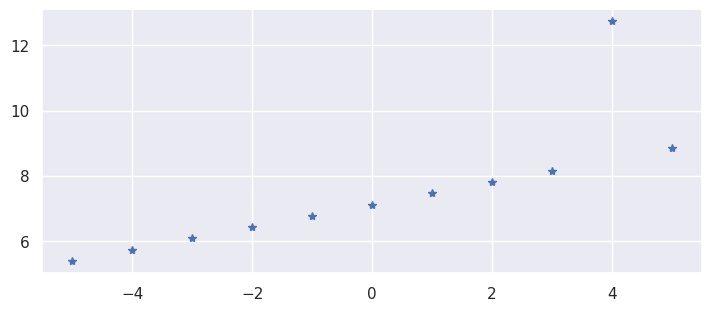

In [2]:
# regression data with outlier
x  = np.array([10.,  8., 13.,  9., 11., 14.,  6.,  4., 12.,  7.,  5.])
y  = np.array([ 7.46,  6.77, 12.74,  7.11,  7.81,  8.84,  6.08,  5.39,  8.15, 6.42,  5.73])

#we  center X
x_c = (x - x.mean())
plt.plot(x_c, y, '*');

In [3]:
s_x = x_c.std()
s_y = y.std()
y_bar = y.mean()

#normal model
with pm.Model() as normal_model:
    #priors on intercept, slope and standard deviation of noise for standardized data
    alpha   = pm.Normal ('alpha', mu=y_bar, sigma=2 * s_y)
    beta    = pm.Normal ('beta',  mu=0,  sigma= 2.5 * s_y / s_x)
    sigma   = pm.HalfNormal ('sigma', sigma= 1.5 * s_y)

    y_pred   = pm.Normal ('y_pred', mu= alpha + beta * x_c,  sigma=sigma, observed=y)

    #the kwargs is needed to store the log_likelihood associated to each sample. Will be used later for a statistical
    #comaprison between the two models
    normal_trace   = pm.sample(idata_kwargs={"log_likelihood": True})

Output()

Output()

In [4]:
#model with student likelihood
with pm.Model() as st_model:
    #priors on intercept, slope and standard deviation of noise for standardized data
    alpha_st   = pm.Normal ('alpha_st', mu=y_bar, sigma=2 * s_y)
    beta_st    = pm.Normal ('beta_st',  mu=0,  sigma= 2.5 * s_y / s_x)
    sigma_st   = pm.HalfNormal ('sigma_st', sigma= 1.5 * s_y)

    y_pred   = pm.StudentT ('y_pred', mu= alpha_st + beta_st * x_c,  sigma=sigma_st, nu=4, observed=y)

    #the kwargs is needed to store the log_likelihood associated to each sample. Will be used later for a statistical
    #comaprison between the two models
    st_trace   = pm.sample(idata_kwargs={"log_likelihood": True})

Output()

Output()

# The Student model fits the correct line

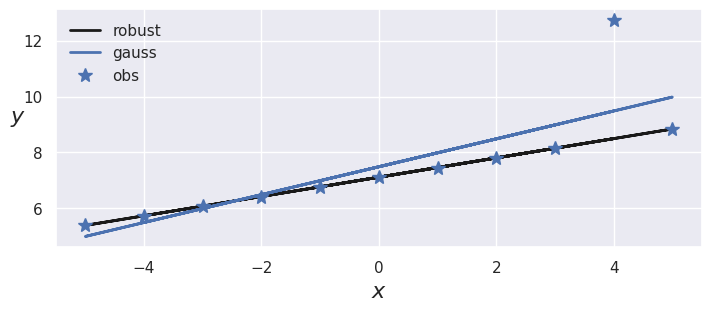

In [5]:
# Display the two models
#posterior mean of the parameters, robust model
post_st    = az.extract_dataset(st_trace)
a_st_hat   = post_st.alpha_st.values.mean()
b_st_hat   = post_st.beta_st.values.mean()

#posterior mean of the parameters, gaussian model
post_gauss  = az.extract_dataset(normal_trace)
a_hat       = post_gauss.alpha.values.mean()
b_hat       = post_gauss.beta.values.mean()

plt.plot(x_c, a_st_hat + b_st_hat * x_c,  c='k', lw=2, label='robust')
plt.plot(x_c,  a_hat + b_hat * x_c,  c='b', lw=2, label='gauss')
plt.plot(x_c, y, '*', markersize=10, label='obs')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend();


# The Student model  provides less uncertain estimates

In [6]:
az.summary(st_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_st,7.114,0.002,7.110,7.118,0.0,0.0,1503.0,981.0,1.0
beta_st,0.345,0.001,0.344,0.347,0.0,0.0,1519.0,1149.0,1.0
sigma_st,0.006,0.004,0.002,0.012,0.0,0.0,618.0,708.0,1.0


In [7]:
az.summary(normal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.488,0.449,6.567,8.281,0.013,0.009,1286.0,1061.0,1.0
beta,0.499,0.141,0.255,0.781,0.004,0.003,1363.0,1194.0,1.0
sigma,1.436,0.408,0.809,2.182,0.012,0.009,1228.0,1003.0,1.0


# The need for statistical model selection

* The model with Student likelihood looks qualitatively better but we need a data-driven criterion to decide.

* In machine learning we use k-fold cross-validation for model selection.

* `loo` (leave-one-out) is k-fold cross validation in which each fold contains only a unique observation.

* The trouble with leave-one-out cross-validation is that, if we have 1000 observations, we need refitting 1000 times the model.

* We will see how WAIC approximates the cross-validation score without actually re-running the model.



# Log-score for categorical variables

* Consider predicting probabilistically the variable {rain, no rain}.
* In table we have the probabilistic prediction by two forecasters, who report their estimated probability of rain.

|  | Day 1 | Day 2 | Day 3 | Day 4 |
|---|:---:|:---:|:---:|:---:|
| Observations | rain | no rain | rain | rain |
|  |  |  |  |  |
| p(rain) |  |  |  |  |
| Forecaster A | 0.6 | 0.4 | 0.6 | 0.7 |
| Forecaster B | 0.5 | 0.4 | 0.5 | 0.6 |


* Log-score: log-probability of the actual event, summed over all days. Higher is better.
  
* The log score of forecaster A is:
$$ \log(.6) + \log(1-.4) + \log(.6) + \log (.7) =  -2.29 $$

* The log score of forecaster B is:
$$ \log(.5) + \log(1-.4) + \log(.5) + \log (.6) =  -2.81 $$

* Forecasters A produces better forecast and his log-score is higher.

* Log-score are negative; hence the higher scores are the 'less negative' ones.

# Log-score for real-valued variables: log-predictive density (lpd)

Consider the prediction for a real-valued variable.

|  | Day 1  | Day 2 | Day 3 | Day 4 |
|---|:---:|:---:|:---:|:---:|
| Observations | 1000 | 1200 | 800 | 780 |
|  |  |  |  |  |
| Prediction |  |  |  |  |
| Forecaster A | $N(800, 100^2)$ | $N(1500, 150^2)$ | $N(750, 50^2)$ | $N(760, 20^2)$ |



* The log score of forecaster A is:

\begin{align*}
\text{log } N(1000 | \mu= 800, \sigma=100) +  \text{log } N(1200 | 1500, 150) + \text{log } N(800 | 750, 50) + \text{log } N(780 | 760, 20)
\end{align*}


* Real-valued variables are predicted with a density. The log-score is referred to as *log-predictive density* (lpd).

In [9]:
# Computing the log score of the above cell
from scipy.stats import norm

lpd = (norm.logpdf(x=1000, loc=800, scale=100) + norm.logpdf(x=1200, loc=1500, scale=150) +
       norm.logpdf(x=800, loc=750, scale=50) + norm.logpdf(x=800, loc=750, scale=50))

print(lpd)


-26.11560562375933


# Recap

 $$ \displaystyle \text{log score} \underbrace{= \text{lpd}}_{\text{real values variables}} = \sum_i^n \log p(y_i)$$

* $p(y_i)$ is the predictive density evaluated in correspondence of the actual value $y_i$

* $n$ is the training set size

* Depending on whether the variable is categorical or numerical, $p$ is a probability or a probability density.


# Bayesian log-score

* Given a model with parameters $\theta$, whose posterior distribution is given in form of samples $\theta_s$ ($s$ = 1,2... 4000)
* Average the log-score over  $\theta_s$
* It is sometimes referred to as 'lppd' (log-pointwise-predictive-density):

  $$ \text{lppd} = \sum_i^n \log \underbrace{\frac{1}{S} \sum_s p(y_i | \theta_s)}_{\text{lpd averaged over parameter samples}} $$

 # Predicting predictive accuracy

 * The lppd is evaluated on the training data.
 * The lppd on test data will be generally worse (more negative)
 * How to estimate the lppd on test data (out-of-sample)?
    * cross-validation (k-fold, leave-one-out); requires refitting the model many times and computing lppd on the data which are left out.
    * as an alternative, information criteria provide a theoretical estimate of the  out-of-sample lppd.

 # WAIC

* WAIC estimates the out-of-sample lppd; its approximation converges to the leave-one-out estimate  in a large sample.

* WAIC is composed by two pieces, computed from posterior samples of the parameters.

* WAIC  = lppd - penalty, where the penalty is proportional to the variance in the posterior predictions.

$$ \text{WAIC} = \text{lppd} - \underbrace{\sum_i \text{var}_{\theta} \log (p(y_i | \theta) )}_{\text{penalty}}$$

> The penalty term means, “compute the variance in log-probabilities for each observation i, and then sum up these variances to get the total penalty.” Each observation has its own penalty. And since these scores measure overfitting risk, you can also assess overfitting risk at the level of each observation. **Stat Rethinking, Sec. 7.2**

*  WAIC decomposes over the individual observations. Indeed some observations are much harder to predict than others and may also have different uncertainty.

*  The above expression of WAIC is in the 'log scale'. Thus, higher (less negative) is better.

*  Other versions of WAIC include a multiplicative constant (-1 or -2) which change the sign of WAIC and have to be interpreted in the opposite way.

 * In `arviz`, specificy `log_scale` when computing WAIC.

#  WAIC of the gaussian and the student model

* We implement:

    * a function which computes lppd
    * a function which computes the penalty.



* We are comparing models with different likelihoods; the density function used in WAIC is normal or student depending on which model we are evaluating.

In [10]:
from scipy.stats import norm
from scipy.stats import t

# computes lppd given a data set of observations (x and y), the posterior samples of parameters alpha, beta and sigma and the type
# of predictive density (normal or st).
# return a vector containing the lppd of each observation
def get_lppd (x, y, alpha, beta, sigma, type='normal'):
    # vector of lppd, one for each observation
    lppd = np.zeros (len(y))
    tmp = np.zeros(len(alpha))

    for i in range(len(y)):
        # vector of 4000 means
        mu = alpha + beta * x[i]

        # the pdf is computed *without* the log. We apply the log later on the average predictive probability.

        if type == 'normal':
            # set of 4000 predictive densities one for each parameter sample
            tmp = norm.pdf(y[i], loc=mu, scale=sigma)
        elif type == 'st':
            tmp = t.pdf(y[i], df=4, loc=mu, scale=sigma)

        avg_pd = np.mean(tmp)
        lppd[i] =  np.log(avg_pd)
    return(lppd)

In [11]:
# for each instance, variance of the log-score across the different samples.
# as in lppd case, we use a density which matches the likelihood of the model
# return a vector with the penalty for each observation.
def get_penalty (x, y, alpha, beta, sigma, type='normal'):
    penalty = np.zeros (len(y))
    tmp = np.zeros(len(alpha))
    for i in range(len(y)):
        # vector of 4000 means
        mu = alpha + beta * x[i]

        if type == 'normal':
            # set of 4000 log-predictive densities for the current sample
            tmp = norm.logpdf(y[i], loc=mu, scale=sigma)
        elif type == 'st':
            tmp = t.logpdf(y[i], df=4, loc=mu, scale=sigma)

        penalty[i] = np.var(tmp)
    return(penalty)

In [12]:
# Posterior samples of the two models

# student model
post_st    = az.extract_dataset(st_trace)
a_st       = post_st.alpha_st.values
b_st       = post_st.beta_st.values
s_st       = post_st.sigma_st.values

# gaussian model
post_gauss  = az.extract_dataset(normal_trace)
a      = post_gauss.alpha.values
b      = post_gauss.beta.values
s      = post_gauss.sigma.values

In [14]:
# densities are not probabilities, they can be larger than 1.
# the student model has summed lppd of 11, much higher than that of the normal model (-21).
lppd_normal = get_lppd (x_c, y, a, b, s, type='normal')
lppd_st  = get_lppd (x_c, y, a_st, b_st, s_st, type='st')



penalty_normal =  get_penalty (x_c, y, a, b, s, type='normal')
penalty_st = get_penalty (x_c, y, a_st, b_st, s_st, type='st')

waic_normal = (lppd_normal.sum() - penalty_normal.sum())
waic_st =  (lppd_st.sum() - penalty_st.sum())

print ("waic_normal: " +  str(waic_normal))
print ("waic_st: " +  str(waic_st))

waic_normal: -21.662812674974052
waic_st: 11.753939312400128


# Decomposing WAIC on each observation



## lppd on each observation

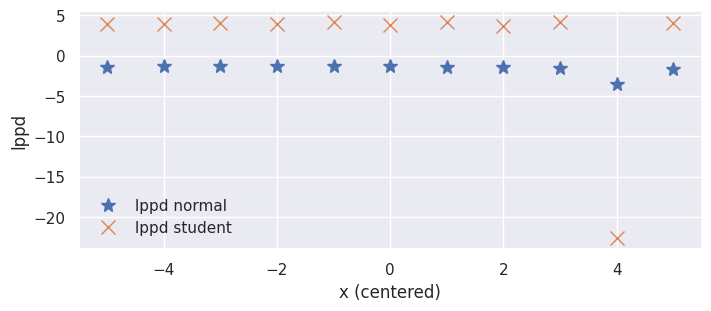

In [17]:
# show the lppd for each point
# both models have a drop of lppd in correspondence of the outlier
# the student model fits better all the non-outliers points, as it correctly estimates the line
plt.plot(x_c, lppd_normal, '*', markersize=10, label='lppd normal')
plt.plot(x_c, lppd_st, 'x', markersize=10, label='lppd student')
plt.legend()
plt.ylabel('lppd')
plt.xlabel('x (centered)');

## Penalty on each observation

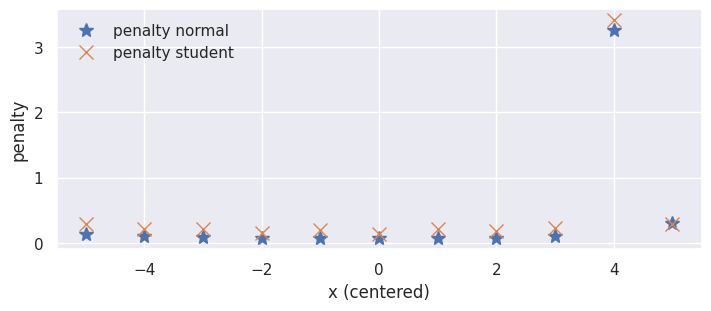

In [20]:
# show the penalty for each point, which is similar for both models
plt.plot(x_c, penalty_normal, '*', markersize=10, label='penalty normal')
plt.plot(x_c, penalty_st, 'x', markersize=10, label='penalty student')
plt.legend()
plt.ylabel('penalty')
plt.xlabel('x (centered)');

## WAIC ( lppd - penalty ) on each observation

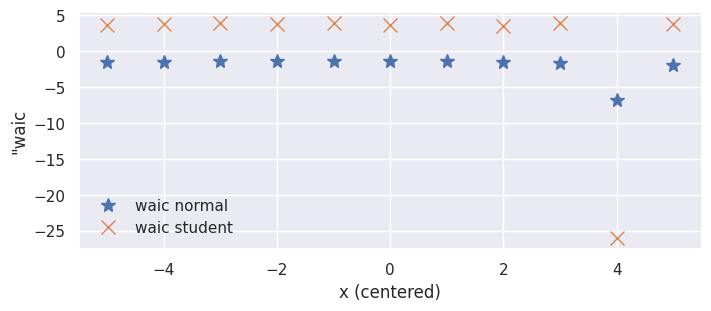

In [19]:
# show the waic for each point (lppd - penalty)
# the final WAIC score is driven more by lppd than by the penalty.
# the student model does not bother about the outlier ('rejects the outlier'), on which it performs poorly
# the normal model tries to fit the outlier; this biases its estimate with smaller lppd on all the non-outlier samples
plt.plot(x_c, lppd_normal - penalty_normal, '*', markersize=10, label='waic normal')
plt.plot(x_c, lppd_st - penalty_st, 'x', markersize=10, label='waic student')
plt.legend()
plt.ylabel('"waic')
plt.xlabel('x (centered)');

# Discussion

* The model with Student likelihood is not bothered by the outlier. It  discards the outlier, fitting correctly the actual line. It provides high lppd on the non-outliers and very low lppd on the outlier.

* The normal model is instead affected by the outlier: it tries to fit the outlier. This biases the model, which performs worse than the Student model on all the non-outlier data.

# WAIC in Pymc
PyMC3 includes two functions for model comparison:
* `compare` computes the  WAIC of a set of given models (remember to specify the log scale).
* `plot_compare` graphically compares the  WAIC of competing models, showing also their uncertainties.

In [ ]:
from arviz import compare

df_comp_WAIC = az.compare({'normal':normal_trace, 'student':st_trace}, ic='waic', scale='log')
df_comp_WAIC

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
student,0,11.155811,6.520989,0.000000,0.908638,28.309138,0.000000,True,log
normal,1,-21.681558,4.471218,32.837369,0.091362,5.132585,23.223663,True,log



1. The first column is the **rank** of the models; zero is best.

2. The second column contains the **values of WAIC**.  **elpd_waic** stands for expected lpd, hence out-of-sample lpd (here, lpd and lppd are used equivalently).

3. The third column is the penalty term. In our case, the normal model has much larger of the log-score across the parameter samples.
When comparing instead models of different complexity (.e.g, regression models with different number of covariates), more complex models are more flexible; it follows have larger variance of the lpd (i.e., higher risk of overfitting) and higher penalty.

5. The fourth column is the **difference between the WAIC of the top-ranked model and the WAIC of each other model**.  It is 0 for the first model.

6. The fifth column contains **model weights** (not covered in this course). Sometimes when comparing models, we do not want to select the "best" model, instead we want to perform predictions by averaging along all the models (or at least several models). Ideally we would like to perform a weighted average, giving more weight to the model that seems to explain/predict the data better. There are many approaches to perform this task, one of them is to use Akaike weights based on the values of WAIC for each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. One caveat of this approach is that the weights are based on point estimates of WAIC (i.e. the uncertainty is ignored).

7. The sixth column records the **standard error for the WAIC computations**. The standard error can be useful to assess the uncertainty of the WAIC estimates. Nevertheless, caution need to be taken because the estimation of the standard error assumes normality and hence could be problematic when the sample size is low.


8. The second-last column is a flag for **warnings**. A value of `True` indicates that the computation of WAIC may not be reliable.

9. The last column indicates the **scale** used for the information criterion.

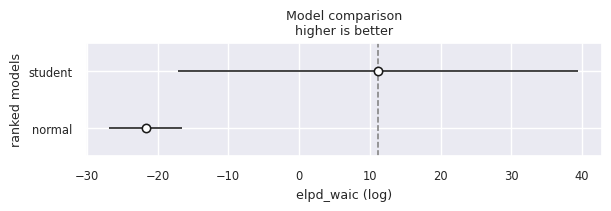

In [ ]:
az.plot_compare(df_comp_WAIC);

# The 'psis-loo' score
  
* An alternative to WAIC is the 'psis-loo' score, which is numerically more realible than WAIC. The derivation of the 'psis-loo' is more complicated and we cannot cover it.

* As the name suggest, 'psis-loo' is an estimate of the leave-one-out lpd, without actually performing leave-one-out.

* In arviz it is referred to as 'loo'.

* Below we show how to use it  and we see that the results are numerically close to those of WAIC.


In [ ]:
from arviz import compare

df_comp_loo = az.compare({'normal':normal_trace, 'student':st_trace}, ic='loo', scale='log')
df_comp_loo

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
student,0,10.493308,7.183492,0.000000,0.908626,28.892244,0.00000,False,log
normal,1,-22.082644,4.872304,32.575952,0.091374,5.464825,23.47604,True,log


# Your turn

* Generate a data set of size $n$=30 from  $Y = 1 + 0.5 X_1 + \epsilon$ with:
    *  $X_1 \sim N(0,1)$
    *  $\epsilon \sim N(0,0.5)$
* Generate two further fictitious covariates $X_2 \sim N(0,1)$.
* Perform model selection between two regression model with different covariates:
    * the first model has covariate $X_1$
    * the second  model has covariate $X_1, X_2$

# Solution

In [ ]:
# generate the data
from scipy.stats import norm

#generate the data
n = 30

# if we do not specify loc and scale, 0 and 1 are assumed
# The X are already centered. If they were not centered, we should center before fitting the model.
x1 = norm.rvs(size=n)
x2 = norm.rvs(size=n)
x3 = norm.rvs(size=n)
y  = 1 + 0.5 * x1 + norm.rvs(size=n, scale=0.5)

In [ ]:
# fit the model with a single covariate
s_x = x1.std()
s_y = y.std()
y_bar = y.mean()

with pm.Model() as x1_model:
    #priors on intercept, slope and standard deviation of noise for standardized data
    alpha   = pm.Normal ('alpha', mu=y_bar, sigma=2 * s_y)
    beta    = pm.Normal ('beta',  mu=0,  sigma= 2.5 * s_y / s_x)
    sigma   = pm.HalfNormal ('sigma', sigma= 1.5 * s_y)

    y_pred   = pm.Normal ('y_pred', mu= alpha + beta * x1,  sigma=sigma, observed=y)

    #the kwargs is needed to store the log_score associated to each sample. Will be used later by WAIC
    x1_trace   = pm.sample(idata_kwargs={"log_likelihood": True})


Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:02

In [ ]:
# fit the model with both covariates
s_x2 = x2.std()

with pm.Model() as x1_2_model:
    #priors on intercept, slope and standard deviation of noise for standardized data
    alpha   = pm.Normal ('alpha', mu=y_bar, sigma=2 * s_y)
    beta    = pm.Normal ('beta',  mu=0,  sigma= 2.5 * s_y / s_x)
    beta2    = pm.Normal ('beta2', mu=0,  sigma= 2.5 * s_y / s_x2)
    sigma   = pm.HalfNormal ('sigma', sigma= 1.5 * s_y)

    # a more elegant implementation is possible, using pm.dot(beta, X) instead of beta * x1 + beta2 * x2
    y_pred   = pm.Normal ('y_pred', mu= alpha + beta * x1 + beta2 * x2,  sigma=sigma, observed=y)

    #the kwargs is needed to store the log_score associated to each sample. Will be used later by WAIC
    x1_2_trace   = pm.sample(idata_kwargs={"log_likelihood": True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:03

In [ ]:
# model selection
df_comp_WAIC = az.compare({'x1':x1_trace, 'x1_2':x1_2_trace}, ic='waic', scale='log')
df_comp_WAIC

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
x1_2,0,-26.284908,3.597530,0.00000,0.510374,3.352449,0.000000,True,log
x1,1,-26.318027,3.009885,0.03312,0.489626,3.619103,1.177887,True,log
